In [375]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

In [376]:
def generate_data(n_samples, t1=3, t2=8, t3=9, thresh_agree=0, low=0, high=10):
    assert(thresh_agree <= 1 and thresh_agree >= 0)
    X1 = np.random.uniform(low, high, size=(n_samples,1))
    X2 = np.random.choice([0, 0.1], size=(n_samples,1))
    X = np.concatenate((X1, X2), axis=1)

    # labels generated according to thresholds
    y = np.zeros(n_samples)
    y[np.where((X[:,0] > t1) & (X[:,0] < t2))] = 1
    y[np.where(X[:, 0] > 9 - thresh_agree)] = 1

    # Groups
    g1_disjoint = np.where((X[:,0] > 0) & (X[:,0] < t3) & (X[:,1] == 0.))
    g1g2 = np.where((X[:,0] > t2) & (X[:,0] < t3))
    g2_disjoint = np.where((X[:,0] > 0) & (X[:,0] < t3) & (X[:,1] == 0.1))

    g1 = np.union1d(g1_disjoint, g1g2)
    g2 = np.union1d(g2_disjoint, g1g2)
    g3 = np.where((X[:,0] > t2))[0]
    g1g2g3 = np.intersect1d(g1g2, g3)

    # Disagreement region
    # Vary between random noise and completely deterministic
    #y[g1g2g3] = np.random.choice([0, 0.1], size=len(g1g2g3), p=[1-noise, noise])
    return X, y, [g1,g2,g3,g1g2,g1g2g3]

In [377]:
def clt_bound(n:int, e:float):
    """Return the lower and upper bound on error rate when test set size is n and empirical error rate is e"""
    assert e >= 0. and e <= 1 and n >= 0, f'Invalid input: n={n}, e={e}'
    a = 4.+n
    b = 2.+n*e
    c = n*e**2
    d = 2.*np.sqrt(1.+n*e*(1.-e))
    return ((b-d)/a, (b+d)/a)

## Sanity Checks
In the following sanity checks, the reported errors are all in-sample.

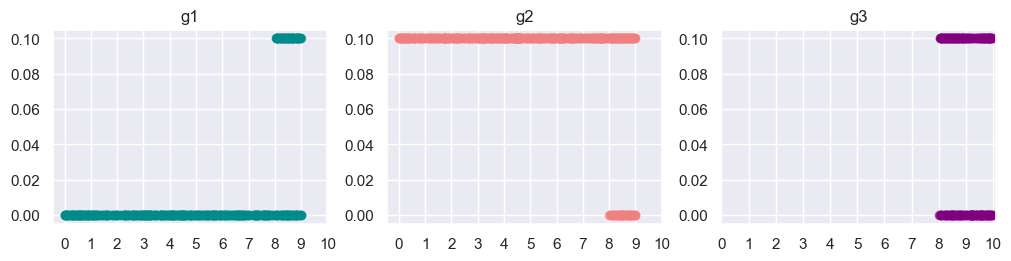

P(g1)=0.49
P(g2)=0.51
P(g3)=0.214
P(g1g2)=0.107
P(g1g2g3)=0.107


In [378]:
# Construct counterexample distribution
# thresholds for changes in P(Y = 1 | X1)
n_samples = 1000
noise = 0
agree = 0.4
X, y, [g1,g2,g3,g1g2,g1g2g3] = generate_data(n_samples=n_samples, 
                                             thresh_agree=agree)
X1 = X[:,0]
X2 = X[:,1]
y0 = np.where(y == 0)


y1 = np.where(y == 1)

# Check groups are okay
fig, axs = plt.subplots(1, 3, figsize=(10, 2.5), layout='constrained')
xticks = range(11)
axs[0].scatter(X1[g1], X2[g1], alpha=0.5, color="darkcyan")
axs[0].set_xticks(xticks)
axs[0].set_title("g1")
axs[1].scatter(X1[g2], X2[g2], alpha=0.5, color="lightcoral")
axs[1].set_xticks(xticks)
axs[1].set_title("g2")
axs[2].scatter(X1[g3], X2[g3], alpha=0.5, color="purple" )
axs[2].set_xticks(xticks)
axs[2].set_title("g3")
plt.show()

# Mass of each group and intersection
print("P(g1)={}".format(len(X[g1])/n_samples))
print("P(g2)={}".format(len(X[g2])/n_samples))
print("P(g3)={}".format(len(X[g3])/n_samples))
print("P(g1g2)={}".format(len(X[g1g2])/n_samples))
print("P(g1g2g3)={}".format(len(X[g1g2g3])/n_samples))

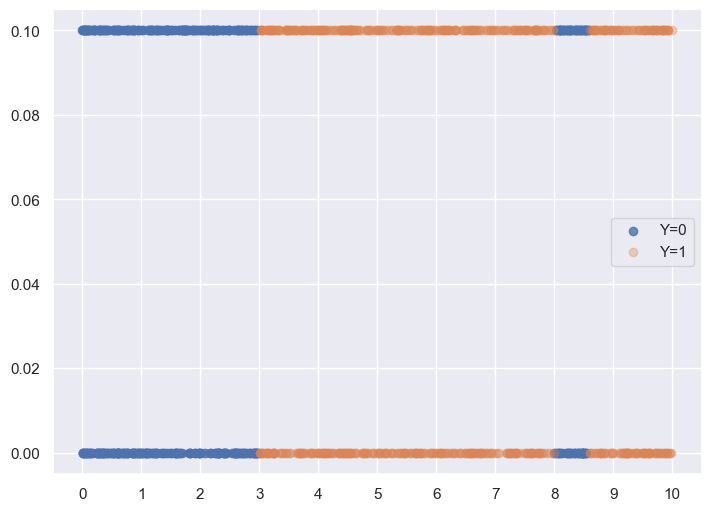

P(Y = 1)=0.653
P(Y = 1 | g1)=0.5795918367346938
P(Y = 1 | g2)=0.6
P(Y = 1 | g3)=0.705607476635514
P(Y = 1 | g1g2)=44.0
P(Y = 1 | g1g2g3)=0.411214953271028


In [379]:
# Plot where Y = 1 (and Y = 0)
fig, ax = plt.subplots(1, 1, figsize=(7, 5), layout='constrained')
ax.set_xticks(xticks)
ax.scatter(X[y0][:,0], X[y0][:,1], alpha=0.8)
ax.scatter(X[y1][:,0], X[y1][:,1], alpha=0.33)
ax.legend(['Y=0', 'Y=1'])
plt.show()

# P(Y = 1) statistics
print("P(Y = 1)={}".format(len(y1[0])/n_samples))
print("P(Y = 1 | g1)={}".format(len(np.intersect1d(y1, g1))/len(g1)))
print("P(Y = 1 | g2)={}".format(len(np.intersect1d(y1, g2))/len(g2)))
print("P(Y = 1 | g3)={}".format(len(np.intersect1d(y1, g3))/len(g3)))
print("P(Y = 1 | g1g2)={}".format(len(np.intersect1d(y1, g1g2))/len(g1g2)))
print("P(Y = 1 | g1g2g3)={}".format(len(np.intersect1d(y1, g1g2g3))/len    (g1g2g3)))

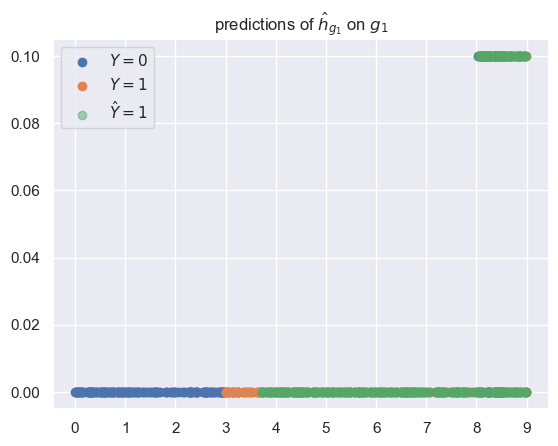

In [380]:
# Sanity check g1
plt.figure()
plt.xticks(xticks)
plt.scatter(X[np.intersect1d(y0, g1)][:,0], X[np.intersect1d(y0,g1)][:,1])
plt.scatter(X[np.intersect1d(y1, g1)][:,0], X[np.intersect1d(y1,g1)][:,1])

modelg1 = LogisticRegression()
modelg1.fit(X[g1], y[g1])
ypredg1 = modelg1.predict(X)
ypredg1 = np.where(ypredg1 == 1)

plt.scatter(X[np.intersect1d(ypredg1, g1)][:,0], 
            X[np.intersect1d(ypredg1,g1)][:,1], alpha=0.5)
plt.title("predictions of $\hat{h}_{g_1}$ on $g_1$")
plt.legend(['$Y = 0$', '$Y = 1$', '$\hat{Y}=1$'])
plt.show()

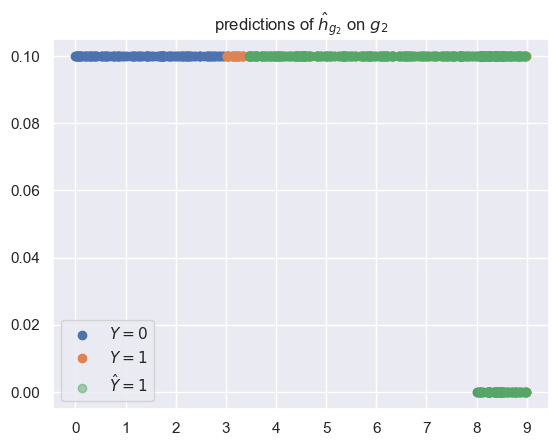

In [381]:
# Sanity check g2
plt.figure()
plt.xticks(xticks)
plt.scatter(X[np.intersect1d(y0, g2)][:,0], X[np.intersect1d(y0,g2)][:,1])
plt.scatter(X[np.intersect1d(y1, g2)][:,0], X[np.intersect1d(y1,g2)][:,1])

modelg2 = LogisticRegression()
modelg2.fit(X[g2], y[g2])
ypredg2 = modelg2.predict(X)
ypredg2 = np.where(ypredg2 == 1)

plt.title("predictions of $\hat{h}_{g_2}$ on $g_2$")
plt.scatter(X[np.intersect1d(ypredg2, g2)][:,0], 
            X[np.intersect1d(ypredg2,g2)][:,1], alpha=0.5)
plt.legend(['$Y = 0$', '$Y = 1$', '$\hat{Y}=1$'])
plt.show()

In [382]:
# Agreement on g1g2
print("L(h1 | g1) = {}".format(1 - accuracy_score(modelg1.predict(X[g1]), 
                                                  y[g1])))
print("L(h2 | g2) = {}".format(1 - accuracy_score(modelg2.predict(X[g2]), 
                                                  y[g2])))
print("Agreement on g1g2: {}".format(accuracy_score(modelg1.predict(X[g1g2]),
                                                    modelg2.predict(X[g1g2]))))

L(h1 | g1) = 0.20612244897959187
L(h2 | g2) = 0.17843137254901964
Agreement on g1g2: 1.0


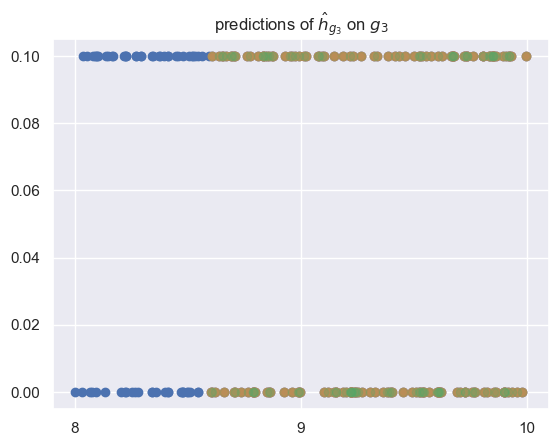

In [383]:
# Sanity check g3
plt.figure()
plt.xticks(xticks)
plt.scatter(X[g3][:,0], X[g3][:,1])
plt.scatter(X[np.intersect1d(y1, g3)][:,0], X[np.intersect1d(y1,g3)][:,1])

modelg3 = LogisticRegression()
modelg3.fit(X[g3], y[g3])
ypredg3 = modelg3.predict(X)
ypredg3 = np.where(ypredg3 == 1)

plt.title("predictions of $\hat{h}_{g_3}$ on $g_3$")
plt.scatter(X[np.intersect1d(ypredg3, g3)][:,0], 
            X[np.intersect1d(ypredg3,g3)][:,1], alpha=0.25)
plt.show()


In [384]:
# Agreement on g1g2g3
print("L(h3 | g3) = {}".format(1 - accuracy_score(modelg3.predict(X[g3]), 
                                                  y[g3])))
print("Agreement on g1g2g3={}".format(accuracy_score(modelg1.predict(X[g1g2g3]),
                                                modelg3.predict(X[g1g2g3]))))

L(h3 | g3) = 0.0
Agreement on g1g2g3=0.411214953271028


In [385]:
# GMV
def gmv_predict(X, models, groups):
    '''
    Predicts with the group majority vote with fitted models. Ties are broken with +1.
    '''
    assert(len(models) == len(groups))

    # Get {-1, +1} predictions for each group
    group_preds = []
    for i, g in enumerate(groups):
        pred = 2 * models[i].predict(X) - 1
        mask = np.ones(len(X), dtype=bool)
        mask[g] = False
        pred[mask] = 0
        group_preds.append(pred)

    # Take majority vote
    pred = np.zeros(len(X))
    for i, g in enumerate(groups):
        pred += group_preds[i]
    pred[np.where(pred > 0)] = 1.
    pred[np.where(pred < 0)] = -1.
    pred[np.where(pred == 0)] = 1.
    
    return pred, group_preds

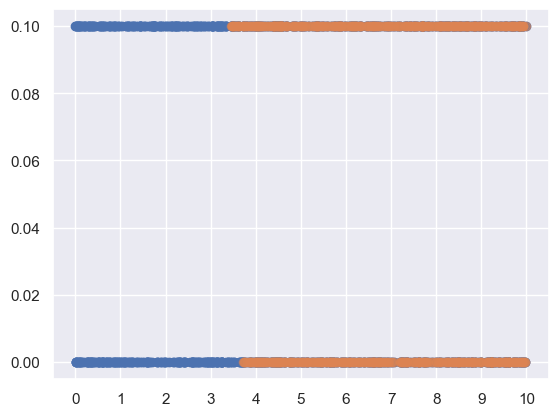

In [386]:
models = [modelg1, modelg2, modelg3]
groups = [g1, g2, g3]

plt.figure()
plt.xticks(xticks)
plt.scatter(X[:,0], X[:,1])
ypred, group_preds = gmv_predict(X, models, groups)
ypred = np.where(ypred == 1)

plt.scatter(X[ypred][:,0], 
            X[ypred][:,1], alpha=0.5)

In [387]:
gmv_pred, group_preds = gmv_predict(X, models, groups)
print("L(gmv | g1)={}".format(accuracy_score(gmv_pred[g1], y[g1])))
print("L(h1 | g3)={}".format(accuracy_score(modelg1.predict(X[g1]), y[g1])))

print("L(gmv | g2)={}".format(accuracy_score(gmv_pred[g2], y[g2])))
print("L(h2 | g3)={}".format(accuracy_score(modelg2.predict(X[g2]), y[g2])))

print("L(gmv | g3)={}".format(accuracy_score(gmv_pred[g3], y[g3])))
print("L(h3 | g3)={}".format(accuracy_score(modelg3.predict(X[g3]), y[g3])))

L(gmv | g1)=0.5020408163265306
L(h1 | g3)=0.7938775510204081
L(gmv | g2)=0.5450980392156862
L(h2 | g3)=0.8215686274509804
L(gmv | g3)=0.705607476635514
L(h3 | g3)=1.0


## Experiments 1: Training error gap

In [404]:
# Parameters for experiment
agreement =  np.linspace(0, 0.5, num=50)
bootstraps = 50
n_samples = 5000

In [405]:
avg_agree = []
avg_agreeg1g2 = []

avgacc_rfall = []
avgacc_rfg1 = []
avgacc_rfg2 = []
avgacc_rfg3 = []

avgacc_h1g1 = []
avgacc_h2g2 = []
avgacc_h3g3 = []

for agree in agreement:
    # generate a new sample of data to get a bootstrap avg on the agreement
    agree_g1g2 = []
    agree_g1g2g3 = []

    acc_rfall = []
    acc_rfg1 = []
    acc_rfg2 = []
    acc_rfg3 = []
    
    acc_h1g1 = []
    acc_h2g2 = []
    acc_h3g3 = []
    for i in range(bootstraps):
        X, y, [g1,g2,g3,g1g2,g1g2g3] = generate_data(n_samples=n_samples,
                                                    thresh_agree=agree)
        
        # Train classifiers
        h1 = LogisticRegression()
        h1.fit(X[g1], y[g1])
        h2 = LogisticRegression()
        h2.fit(X[g2], y[g2])
        h3 = LogisticRegression()
        h3.fit(X[g3], y[g3])
        models = [h1, h2, h3]
        groups = [g1, g2, g3]

        # Get agreement
        agree_g1g2.append(accuracy_score(h1.predict(X[g1g2]), 
                                               h2.predict(X[g1g2])))
        agree_g1g2g3.append(accuracy_score(h1.predict(X[g1g2g3]),
                                                 h3.predict(X[g1g2g3])))
        
        # Get training accuracies
        gmv_pred, group_preds = gmv_predict(X, models, groups)
        acc_rfall.append(accuracy_score(gmv_pred, y))
        acc_rfg1.append(1 - accuracy_score(gmv_pred[g1], y[g1]))
        acc_rfg2.append(1 - accuracy_score(gmv_pred[g2], y[g2]))
        acc_rfg3.append(1 - accuracy_score(gmv_pred[g3], y[g3]))

        acc_h1g1.append(1 - accuracy_score(h1.predict(X[g1]), y[g1]))
        acc_h2g2.append(1 - accuracy_score(h2.predict(X[g2]), y[g2]))
        acc_h3g3.append(1 - accuracy_score(h3.predict(X[g3]), y[g3]))

    # Get average agreement
    avg_agreeg1g2.append(sum(agree_g1g2)/ len(agree_g1g2))
    avg_agree.append(sum(agree_g1g2g3)/len(agree_g1g2g3))
    
    # Get average accuracies
    avgacc_rfall.append(sum(acc_rfall)/len(acc_rfall))
    avgacc_rfg1.append(sum(acc_rfg1)/len(acc_rfg1))
    avgacc_rfg2.append(sum(acc_rfg2)/len(acc_rfg2))
    avgacc_rfg3.append(sum(acc_rfg3)/len(acc_rfg3))

    avgacc_h1g1.append(sum(acc_h1g1)/len(acc_h1g1))
    avgacc_h2g2.append(sum(acc_h2g2)/len(acc_h2g2))
    avgacc_h3g3.append(sum(acc_h3g3)/len(acc_h3g3))

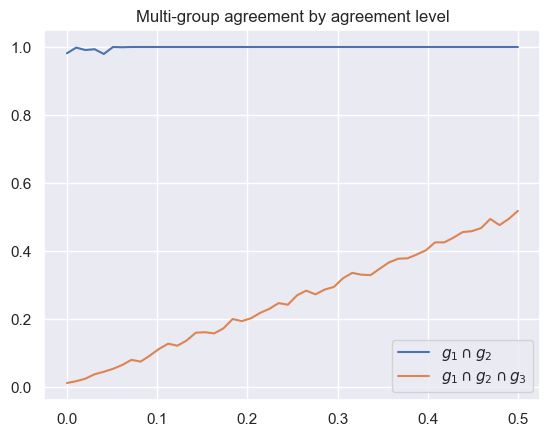

In [ ]:
# Plot 1: Agreement
fig, ax = plt.subplots()
ax.plot(agreement, avg_agreeg1g2, label='$g_1 \cap g_2$')
ax.plot(agreement, avg_agree, label='$g_1 \cap g_2 \cap g_3$')
ax.set_title('Multi-group agreement by agreement level')
ax.legend()
plt.show()

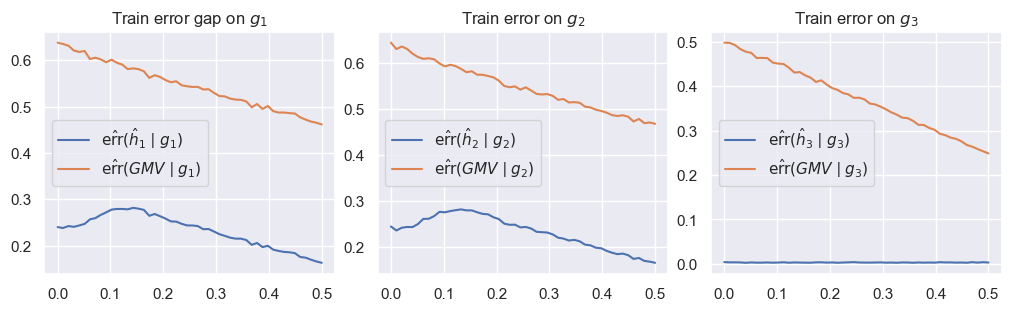

In [406]:
# Plot 2: Error of h3 vs rf on g3
fig, axs = plt.subplots(1, 3, figsize=(10, 3), layout='constrained')

# g1
axs[0].plot(agreement, avgacc_h1g1, 
        label='$\hat{\mathrm{err}}(\hat{h}_1 \mid g_1)$')
axs[0].plot(agreement, avgacc_rfg1, 
        label='$\hat{\mathrm{err}}(GMV \mid g_1)$')
axs[0].set_title('Train error gap on $g_1$')
axs[0].legend()

# g2
axs[1].plot(agreement, avgacc_h2g2, 
        label='$\hat{\mathrm{err}}(\hat{h}_2 \mid g_2)$')
axs[1].plot(agreement, avgacc_rfg2, 
        label='$\hat{\mathrm{err}}(GMV \mid g_2)$')
axs[1].set_title('Train error on $g_2$')
axs[1].legend()

# g3
axs[2].plot(agreement, avgacc_h3g3, 
        label='$\hat{\mathrm{err}}(\hat{h}_3 \mid g_3)$')
axs[2].plot(agreement, avgacc_rfg3, 
        label='$\hat{\mathrm{err}}(GMV \mid g_3)$')
axs[2].set_title('Train error on $g_3$')
axs[2].legend()
plt.show()

## Experiments 2: Test error gap

In [407]:
# Parameters for experiment
agreement =  np.linspace(0, 0.5, num=50)
bootstraps = 50
n_samples = 5000

In [411]:
avg_agree = []
avg_agreeg1g2 = []

avgacc_rfall = []
avgacc_rfg1 = []
avgacc_rfg2 = []
avgacc_rfg3 = []

avgacc_h1g1 = []
avgacc_h2g2 = []
avgacc_h3g3 = []

conf_rfall = []
conf_rfg1 = []
conf_rfg2 = []
conf_rfg3 = []
conf_h1 = []
conf_h2 = []
conf_h3 = []

for agree in agreement:
    # generate a new sample of data to get a bootstrap avg on the agreement
    agree_g1g2 = []
    agree_g1g2g3 = []

    acc_rfall = []
    acc_rfg1 = []
    acc_rfg2 = []
    acc_rfg3 = []
    
    acc_h1g1 = []
    acc_h2g2 = []
    acc_h3g3 = []
    for i in range(bootstraps):
        X, y, [g1,g2,g3,g1g2,g1g2g3] = generate_data(n_samples=n_samples,
                                                    thresh_agree=agree)
        X_test, y_test, [g1_test,g2_test, g3_test, g1g2_test, g1g2g3_test] = generate_data(n_samples=n_samples, thresh_agree=agree)
        
        # Train classifiers
        h1 = LogisticRegression()
        h1.fit(X[g1], y[g1])
        h2 = LogisticRegression()
        h2.fit(X[g2], y[g2])
        h3 = LogisticRegression()
        h3.fit(X[g3], y[g3])
        models = [h1, h2, h3]
        groups = [g1, g2, g3]

        # Get agreement
        agree_g1g2.append(accuracy_score(h1.predict(X[g1g2]), 
                                               h2.predict(X[g1g2])))
        agree_g1g2g3.append(accuracy_score(h1.predict(X[g1g2g3]),
                                                 h3.predict(X[g1g2g3])))
        
        # Get training accuracies
        gmv_pred, group_preds = gmv_predict(X_test, models, groups)
        acc_rfall.append(accuracy_score(gmv_pred, y))
        acc_rfg1.append(1 - accuracy_score(gmv_pred[g1], y[g1]))
        acc_rfg2.append(1 - accuracy_score(gmv_pred[g2], y[g2]))
        acc_rfg3.append(1 - accuracy_score(gmv_pred[g3], y[g3]))

        acc_h1g1.append(1 - accuracy_score(h1.predict(X_test[g1]), y_test[g1]))
        acc_h2g2.append(1 - accuracy_score(h2.predict(X_test[g2]), y_test[g2]))
        acc_h3g3.append(1 - accuracy_score(h3.predict(X_test[g3]), y_test[g3]))

    # Get average agreement
    avg_agreeg1g2.append(sum(agree_g1g2)/ len(agree_g1g2))
    avg_agree.append(sum(agree_g1g2g3)/len(agree_g1g2g3))

    conf_rfall.append(np.sqrt(np.var(acc_rfall)))
    conf_rfg1.append(np.sqrt(np.var(acc_rfg1)))
    conf_rfg2.append(np.sqrt(np.var(acc_rfg2)))
    conf_rfg3.append(np.sqrt(np.var(acc_rfg3)))

    conf_h1.append(np.sqrt(np.var(acc_h1g1)))
    conf_h2.append(np.sqrt(np.var(acc_h2g2)))
    conf_h3.append(np.sqrt(np.var(acc_h3g3)))
    
    # Get average accuracies
    avgacc_rfall.append(sum(acc_rfall)/len(acc_rfall))
    avgacc_rfg1.append(sum(acc_rfg1)/len(acc_rfg1))
    avgacc_rfg2.append(sum(acc_rfg2)/len(acc_rfg2))
    avgacc_rfg3.append(sum(acc_rfg3)/len(acc_rfg3))

    avgacc_h1g1.append(sum(acc_h1g1)/len(acc_h1g1))
    avgacc_h2g2.append(sum(acc_h2g2)/len(acc_h2g2))
    avgacc_h3g3.append(sum(acc_h3g3)/len(acc_h3g3))

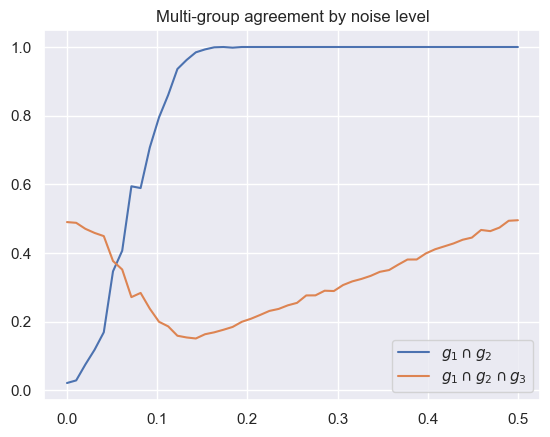

In [412]:
# Plot 1: Agreement
fig, ax = plt.subplots()
ax.plot(agreement, avg_agreeg1g2, label='$g_1 \cap g_2$')
ax.plot(agreement, avg_agree, label='$g_1 \cap g_2 \cap g_3$')
ax.set_title('Multi-group agreement by agreement level')
ax.legend()
plt.show()

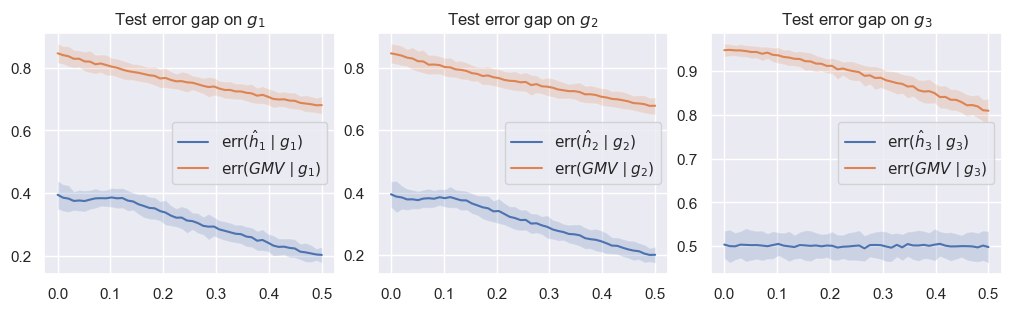

In [414]:
# Plot 2: Error of h3 vs rf on g3
fig, axs = plt.subplots(1, 3, figsize=(10, 3), layout='constrained')

# g1
axs[0].plot(agreement, avgacc_h1g1, 
        label='$\mathrm{err}(\hat{h}_1 \mid g_1)$')
axs[0].fill_between(agreement, 
                    np.array(avgacc_h1g1) - 2 * np.array(conf_h1), 
                    np.array(avgacc_h1g1) + 2 * np.array(conf_h1),
                    alpha=0.2, antialiased=True)
axs[0].plot(agreement, avgacc_rfg1, 
        label='$\mathrm{err}(GMV \mid g_1)$')
axs[0].fill_between(agreement, 
                    np.array(avgacc_rfg1) - 2 * np.array(conf_rfg1), 
                    np.array(avgacc_rfg1) + 2 * np.array(conf_rfg1),
                    alpha=0.2, antialiased=True)
axs[0].set_title('Test error gap on $g_1$')
axs[0].legend()

# g2
axs[1].plot(agreement, avgacc_h2g2, 
        label='$\mathrm{err}(\hat{h}_2 \mid g_2)$')
axs[1].fill_between(agreement, 
                    np.array(avgacc_h2g2) - 2 * np.array(conf_h2), 
                    np.array(avgacc_h2g2) + 2 * np.array(conf_h2),
                    alpha=0.2, antialiased=True)
axs[1].plot(agreement, avgacc_rfg2, 
        label='$\mathrm{err}(GMV \mid g_2)$')
axs[1].fill_between(agreement, 
                    np.array(avgacc_rfg2) - 2 * np.array(conf_rfg2), 
                    np.array(avgacc_rfg2) + 2 * np.array(conf_rfg2),
                    alpha=0.2, antialiased=True)
axs[1].set_title('Test error gap on $g_2$')
axs[1].legend()

# g3
axs[2].plot(agreement, avgacc_h3g3, 
        label='$\mathrm{err}(\hat{h}_3 \mid g_3)$')
axs[2].fill_between(agreement, 
                    np.array(avgacc_h3g3) - 2 * np.array(conf_h3), 
                    np.array(avgacc_h3g3) + 2 * np.array(conf_h3),
                    alpha=0.2, antialiased=True)
axs[2].plot(agreement, avgacc_rfg3, 
        label='$\mathrm{err}(GMV \mid g_3)$')
axs[2].fill_between(agreement, 
                    np.array(avgacc_rfg3) - 2 * np.array(conf_rfg3), 
                    np.array(avgacc_rfg3) + 2 * np.array(conf_rfg3),
                    alpha=0.2, antialiased=True)
axs[2].set_title('Test error gap on $g_3$')
axs[2].legend()
plt.show()

Text(0.5, 1.0, '$\\mathrm{err}(GMV \\mid g_3) - \\mathrm{err}(\\hat{h}_{g_3} \\mid g_3)$')

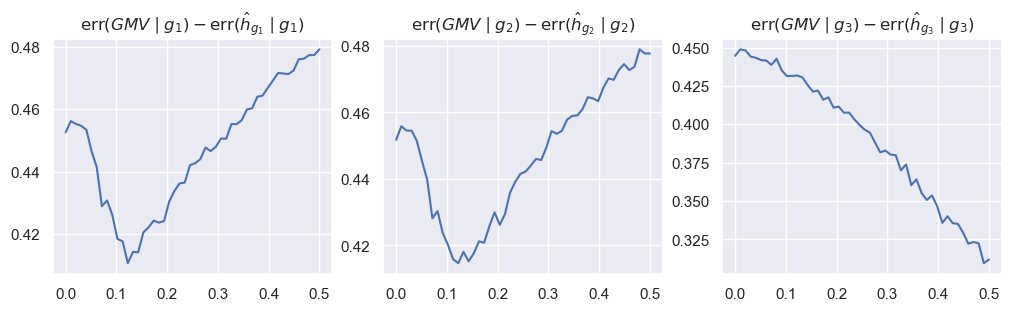

In [424]:
# Plot 3: Excess test errors
fig, axs = plt.subplots(1, 3, figsize=(10, 3), layout='constrained')
excessg1 = np.array(avgacc_rfg1) - np.array(avgacc_h1g1)
excessg2 = np.array(avgacc_rfg2) - np.array(avgacc_h2g2)
excessg3 = np.array(avgacc_rfg3) - np.array(avgacc_h3g3)

axs[0].plot(agreement, excessg1, 
        label='$\mathrm{err}(\hat{h}_1 \mid g_1)$')
axs[0].set_title('$\mathrm{err}(GMV \mid g_1) - \mathrm{err}(\hat{h}_{g_1} \mid g_1)$')

axs[1].plot(agreement, excessg2, 
        label='$\mathrm{err}(\hat{h}_1 \mid g_2)$')
axs[1].set_title('$\mathrm{err}(GMV \mid g_2) - \mathrm{err}(\hat{h}_{g_2} \mid g_2)$')

axs[2].plot(agreement, excessg3, 
        label='$\mathrm{err}(\hat{h}_1 \mid g_3)$')
axs[2].set_title('$\mathrm{err}(GMV \mid g_3) - \mathrm{err}(\hat{h}_{g_3} \mid g_3)$')